In [62]:
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import skimage
from sklearn.cluster import KMeans

In [83]:
def binary_seg_kMeans(img):
    binary = np.zeros_like(img)
    pixels = img.reshape(-1, 1)
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(pixels)
    centers = kmeans.cluster_centers_
    thresh = (centers[0] + centers[1])/2
    binary[img > thresh] = 1
    return binary

In [75]:
def contrast_stretching(input_image):
    #Contrast stretching
    #Dropping extreems (artifacts)
    p2, p98 = np.percentile(input_image, (2, 98))
    stretched_image = skimage.exposure.rescale_intensity(input_image, in_range=(p2, p98))
    return stretched_image.astype('uint8')

In [ ]:
def pre_processing (path, s):
    
    img = tifffile.imread(path)
    img = img[s[0]:s[1],s[2]:s[3],s[4]:s[5]]
    img = contrast_stretching(img).astype('uint8')
    
    return img
    

In [26]:
def pixel_metrics(pred, target):
    
    mse = skimage.metrics.mean_squared_error(target, pred)
    mi = skimage.metrics.normalized_mutual_information(target, pred, bins=100)
    psnr = skimage.metrics.peak_signal_noise_ratio(target, pred, data_range=None)
    ssi = skimage.metrics.structural_similarity(target, pred, win_size=None, gradient=False,
                                                data_range=None, channel_axis=None,
                                                gaussian_weights=False, full=False,)
    
    return {'mse':mse, 'mi':mi, 'psnr':psnr, 'ssi':ssi}

In [86]:
def microstructure_metric(img):
    ice_density = 0.92 #(g/cm³)
    pixel_volume = (0.006)**3 # cm³
    voxel = 0.006 #cm
    
    relative_density = round(len(img[img>0])/img.size,2)
    density = relative_density * ice_density
    
    porosity = round (len (img[img==0])*100/img.size,2)
    
    verts, faces, _, _ = skimage.measure.marching_cubes(img, level=0)
    surface_area = skimage.measure.mesh_surface_area(verts, faces)
    SSA =round( (surface_area * voxel * voxel),2) # mm^2
    
    #For 3D objects, the Euler number is obtained as the number of objects
    #plus the number of holes, minus the number of tunnels, or loops.
    euler = skimage.measure.euler_number(img, connectivity=1)
    
    return density,porosity,SSA,euler

In [87]:
m = microstructure_metric(binary)
print (m)

(0.874, 5.13, 60.68)


In [ ]:
snow_slice = [10,410,800,1200,200,600]
firn_slice = [10,410,600,1000,1200,1600]
ice_slice= [10,410,200,600,800,1200]

In [61]:
for f in snow_files:
    print (snow_files[f])

data/registered_image02_3dCT_B40_bag12_13_300mm.tif
data/02_Substack (6267-6662)_B40_bag12_13.tif
model_output/02_Substack_predictions_SRCNN_.tif
model_output/02_Substack_predictions_DCSRN_.tif
model_output/02_Substack_predictions_SRUnet_.tif
model_output/02_Substack_predictions_SRResnet_.tif


In [54]:
snow_files = {'High-res': 'data/registered_image02_3dCT_B40_bag12_13_300mm.tif',
              'Bicubic' : 'data/02_Substack (6267-6662)_B40_bag12_13.tif',
              'SRCNN'   : 'model_output/02_Substack_predictions_SRCNN_.tif',
              'DCSRN'   : 'model_output/02_Substack_predictions_DCSRN_.tif',
              'SRUnet'  : 'model_output/02_Substack_predictions_SRUnet_.tif',
              'SRResnet': 'model_output/02_Substack_predictions_SRResnet_.tif'}

In [55]:
firn_files = {'High-res': 'data/registered_image06_3dCT_B40_bag56_57_100mm.tif',
              'Bicubic' : 'data/06_Substack (8055-8449)_B40_bag56_57.tif',
              'SRCNN'   : 'model_output/06_Substack_predictions_SRCNN_.tif',
              'DCSRN'   : 'model_output/06_Substack_predictions_DCSRN_.tif',
              'SRUnet'  : 'model_output/06_Substack_predictions_SRUnet_.tif',
              'SRResnet': 'model_output/06_Substack_predictions_SRResnet_.tif'}


In [56]:
ice_files = {'High-res': 'data/registered_image10_3dCT_B40_bag108_109_538mm.tif',
              'Bicubic' : 'data/10_Substack (4268-4663)_B40_bag108_109.tif',
              'SRCNN'   : 'model_output/10_Substack_predictions_SRCNN_.tif',
              'DCSRN'   : 'model_output/10_Substack_predictions_DCSRN_.tif',
              'SRUnet'  : 'model_output/10_Substack_predictions_SRUnet_.tif',
              'SRResnet': 'model_output/10_Substack_predictions_SRResnet_.tif'}

In [65]:
pred = tifffile.imread('model_output/10_Substack_predictions_DCSRN_.tif')
#target = tifffile.imread('data/registered_image02_3dCT_B40_bag12_13_300mm.tif')

In [66]:
pred = pred[10:410,200:600,800:1200]

In [67]:
pred = contrast_stretching(pred)

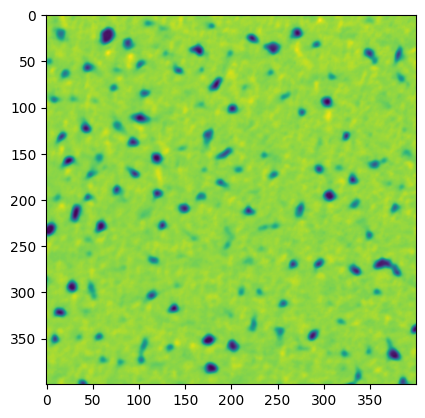

In [53]:
plt.imshow(pred[10,410,200,600,800,1200])

In [33]:
pred = pred[10:410,800:1200,200:600].astype('uint8')
target = target [10:410,800:1200,200:600].astype('uint8')

In [34]:
target = contrast_stretching(target)
pred = contrast_stretching(pred)

In [36]:
metrics = pixel_metrics(pred=pred, target=target)
print (metrics)

{'mse': 2017.5738945625, 'mi': 1.0927149512198755, 'psnr': 15.082509109493724, 'ssi': 0.7220322964353744}


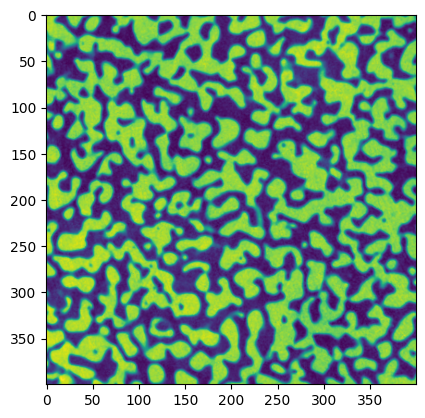

In [14]:
plt.imshow(target[0])

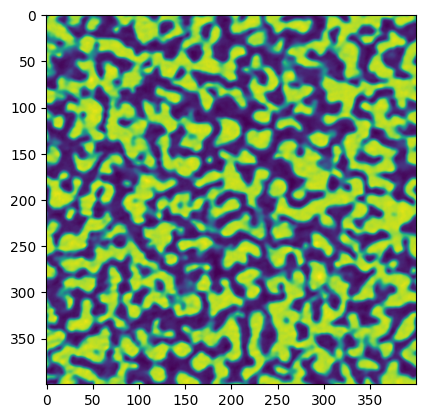

In [10]:
plt.imshow(data[0])